<a href="https://colab.research.google.com/github/ahmetezzgi/BrainMRI_Classification/blob/main/Covid_Classical_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
import math
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
IMAGE_FORMAT = ["jpeg", "jpg", "png"]

def list_image_files(data_dir, sub_dir):
    image_files = []
    images_dir = os.path.join(data_dir, sub_dir)
    for file_path in os.listdir(images_dir):
        if file_path.split(".")[-1] in IMAGE_FORMAT:
            image_files.append(os.path.join(sub_dir, file_path))
    return image_files

In [4]:
# ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import ImageFilter

height, width = 224, 224
batch_size=64


def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.)
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

TRAINING_DIR = '/content/drive/MyDrive/Covid19-dataset/train'
TESTING_DIR = '/content/drive/MyDrive/Covid19-dataset/test'

train_generator = generate_data(TRAINING_DIR)
test_generator = generate_data(TESTING_DIR)

total_image = np.concatenate([train_generator.labels,test_generator.labels])

print('\n\n',{'Normal_cases':len(np.where(total_image==0)[0]),
      'Viral_Pneumonia_cases':len(np.where(total_image==1)[0]),
             'Covid_cases':len(np.where(total_image==2)[0])})

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


 {'Normal_cases': 90, 'Viral_Pneumonia_cases': 90, 'Covid_cases': 137}


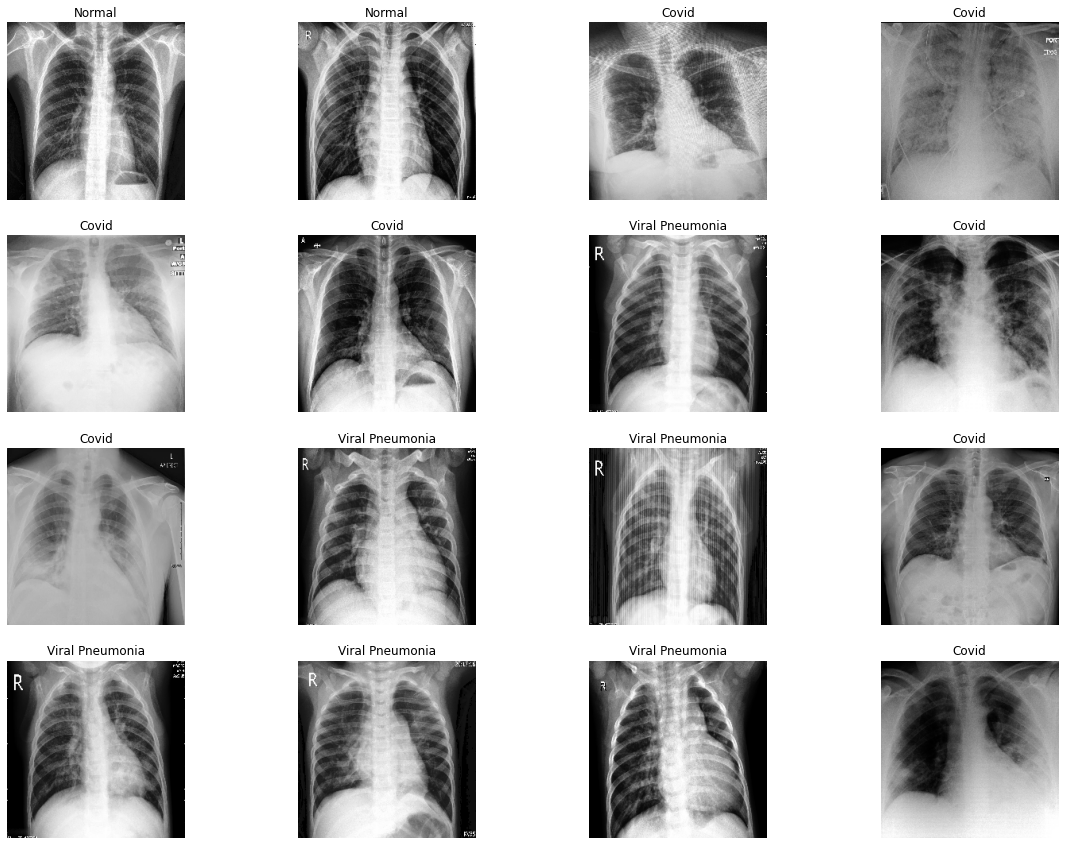

In [13]:
def image_plot(generator,image_numbers):
    img_feature = generator[0][0][:image_numbers]
    img_label = generator[0][1][:image_numbers]

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(img_feature[i])
        plt.title("Normal" if img_label[i] == 0 else "Viral Pneumonia" if img_label[i] == 1 else "Covid")
        plt.axis("off")

image_plot(train_generator,16)

In [5]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg16 = tf.keras.Sequential()
model_vgg16.add(base_model)
model_vgg16.add(tf.keras.layers.GlobalAveragePooling2D())

model_vgg16.add(tf.keras.layers.Flatten())
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))

model_vgg16.add(tf.keras.layers.Dense(3, activation='softmax'))

model_vgg16.compile(loss='SparseCategoricalCrossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])
model_vgg16.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65

In [6]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

callbacks_list = [checkpoint,early]

history = model_vgg16.fit(
        train_generator,
        validation_data = test_generator,
        #steps_per_epoch=10,
        epochs=50, 
        shuffle=False, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/50
4/4 [==============================] - ETA: 0s - loss: 1.2083 - acc: 0.3785 
Epoch 1: acc improved from -inf to 0.37849, saving model to model/vgg16_best.h5
4/4 [==============================] - 67s 18s/step - loss: 1.2083 - acc: 0.3785 - val_loss: 1.0454 - val_acc: 0.3939
Epoch 2/50
4/4 [==============================] - ETA: 0s - loss: 1.1164 - acc: 0.4303
Epoch 2: acc improved from 0.37849 to 0.43028, saving model to model/vgg16_best.h5
4/4 [==============================] - 12s 3s/step - loss: 1.1164 - acc: 0.4303 - val_loss: 0.9692 - val_acc: 0.3939
Epoch 3/50
4/4 [==============================] - ETA: 0s - loss: 0.9846 - acc: 0.5100
Epoch 3: acc improved from 0.43028 to 0.50996, saving model to model/vgg16_best.h5
4/4 [==============================] - 12s 3s/step - loss: 0.9846 - acc: 0.5100 - val_loss: 0.9018 - val_acc: 0.6515
Epoch 4/50
4/4 [==============================] - ETA: 0s - loss: 0.9083 - acc: 0.5378
Epoch 4: acc improved from 0.50996 to 0.53785, saving

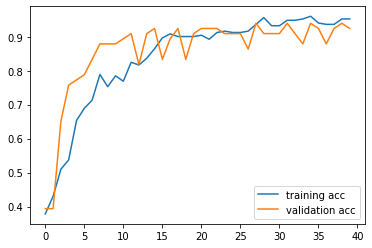

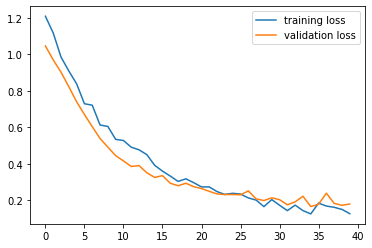

In [7]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend();

plot_learning_curve(history)

In [8]:
train_result = model_vgg16.evaluate(train_generator)
test_result = model_vgg16.evaluate(test_generator)

no_augmented_df = pd.DataFrame(zip(train_result,test_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

2/2 [==============================] - 2s 8ms/step - loss: 0.1657 - acc: 0.9394


,Train,Val
Loss,0.101334,0.165685
Acc,0.968127,0.939394


              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90        20
         1.0       0.90      0.90      0.90        20
         2.0       1.00      1.00      1.00        26

    accuracy                           0.94        66
   macro avg       0.93      0.93      0.93        66
weighted avg       0.94      0.94      0.94        66



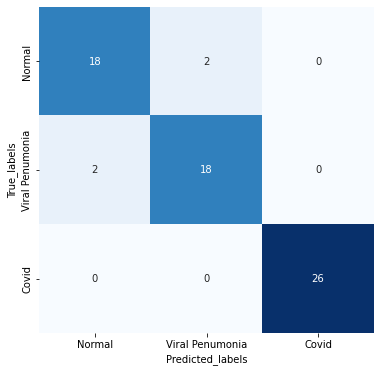

In [9]:
ytest = np.array([])
xtest = []

for i in range(math.ceil(len(test_generator.classes)/batch_size)):
    xtest.append(test_generator[i][0]) 
    ytest= np.concatenate((ytest,test_generator[i][-1])) 
    
xtest = np.concatenate((xtest),axis=0)

ypred_prob =model_vgg16.predict(xtest)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytest,ypred))

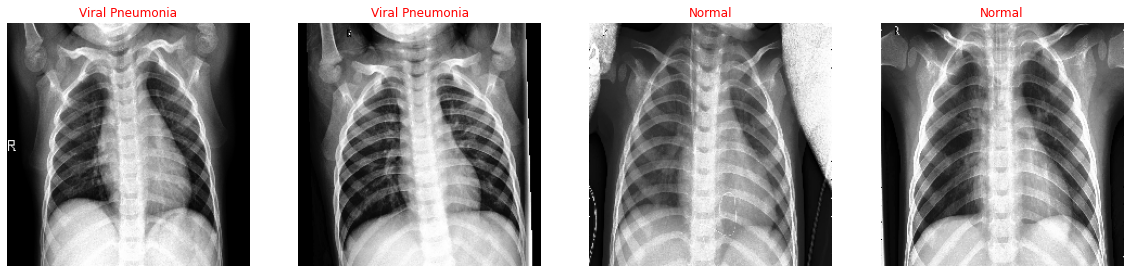

In [10]:
#Extract wrong classification index
wrong_pred = np.where(ypred!=ytest)[0]

plt.figure(figsize=(20, 15))
for i,n in enumerate(wrong_pred):
    ax = plt.subplot(math.ceil(len(wrong_pred)/4),4, i + 1)
    plt.imshow(xtest[n])
    plt.title("Normal" if ypred[n] == 0 else "Viral Pneumonia" if ypred[n] == 1 else "Covid",color='r')
    plt.axis("off")

Found 251 images belonging to 3 classes.


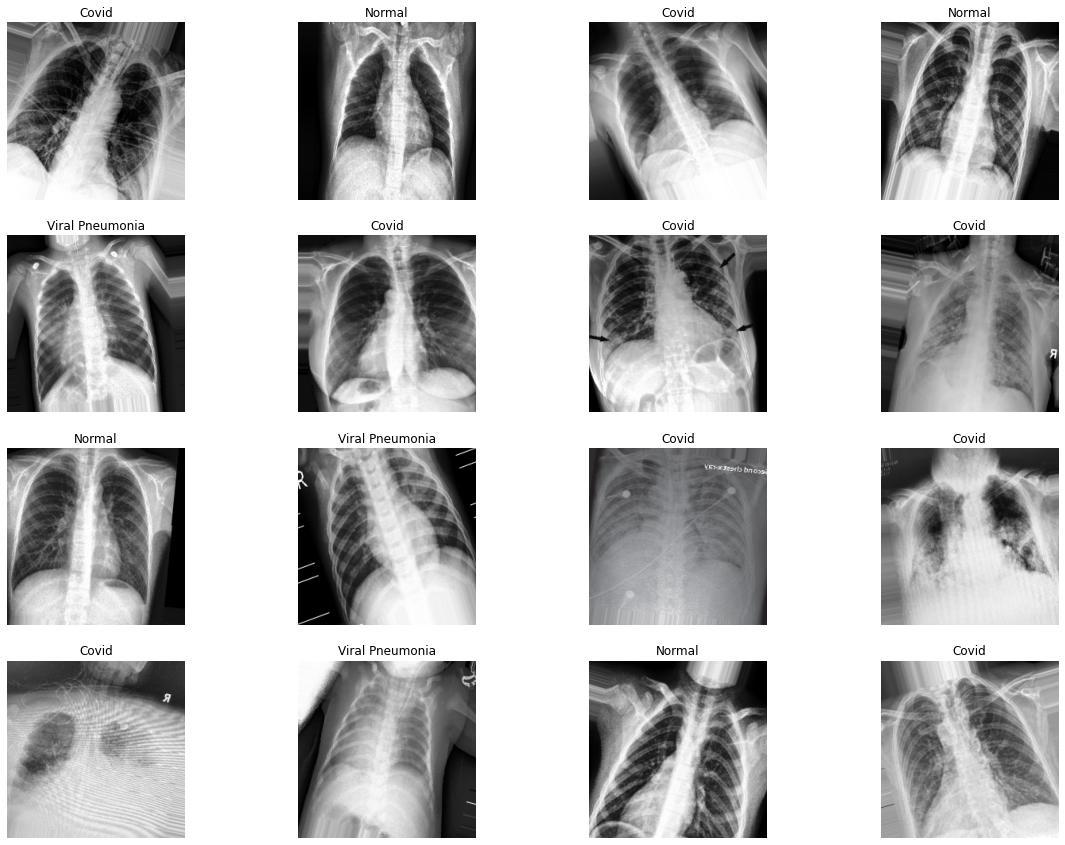

In [15]:
def generate_data_augmented(DIR):
    datagen = ImageDataGenerator(
        rescale=1./255.,
        zoom_range=0.1,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True
    )
    generator = datagen.flow_from_directory(
        TRAINING_DIR,
        batch_size=batch_size,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

aug_train_generator = generate_data_augmented(TRAINING_DIR)

image_plot(aug_train_generator,16)

In [16]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=10)

callbacks_list = [checkpoint,early]

history = model_vgg16.fit(
        aug_train_generator,
        validation_data = test_generator,
        #steps_per_epoch=10,
        epochs=60, 
        shuffle=False, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/60
4/4 [==============================] - ETA: 0s - loss: 0.2418 - acc: 0.9163
Epoch 1: acc improved from -inf to 0.91633, saving model to model/vgg16_best.h5
4/4 [==============================] - 16s 4s/step - loss: 0.2418 - acc: 0.9163 - val_loss: 0.1871 - val_acc: 0.9242
Epoch 2/60
4/4 [==============================] - ETA: 0s - loss: 0.2804 - acc: 0.8884
Epoch 2: acc did not improve from 0.91633
4/4 [==============================] - 14s 4s/step - loss: 0.2804 - acc: 0.8884 - val_loss: 0.1603 - val_acc: 0.9394
Epoch 3/60
4/4 [==============================] - ETA: 0s - loss: 0.2831 - acc: 0.8884
Epoch 3: acc did not improve from 0.91633
4/4 [==============================] - 14s 4s/step - loss: 0.2831 - acc: 0.8884 - val_loss: 0.1621 - val_acc: 0.9545
Epoch 4/60
4/4 [==============================] - ETA: 0s - loss: 0.2566 - acc: 0.9004
Epoch 4: acc did not improve from 0.91633
4/4 [==============================] - 14s 4s/step - loss: 0.2566 - acc: 0.9004 - val_loss: 0.2

In [17]:
train_result = model_vgg16.evaluate(train_generator)
test_result = model_vgg16.evaluate(test_generator)

augmented_df = pd.DataFrame(zip(train_result,test_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

2/2 [==============================] - 1s 7ms/step - loss: 0.1111 - acc: 0.9848


,Train,Val
Loss,0.061464,0.111125
Acc,0.980080,0.984848


              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97        70
         1.0       0.99      0.94      0.96        70
         2.0       1.00      1.00      1.00       111

    accuracy                           0.98       251
   macro avg       0.98      0.98      0.98       251
weighted avg       0.98      0.98      0.98       251



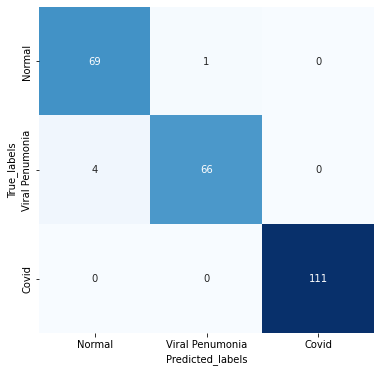

In [18]:
ytrain = np.array([])
xtrain = []

for i in range(math.ceil(len(train_generator.classes)/batch_size)):
    xtrain.append(train_generator[i][0]) 
    ytrain= np.concatenate((ytrain,train_generator[i][-1])) 
    
xtrain = np.concatenate((xtrain),axis=0)

ypred_prob =model_vgg16.predict(xtrain)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytrain,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytrain,ypred))

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97        20
         1.0       0.95      1.00      0.98        20
         2.0       1.00      1.00      1.00        26

    accuracy                           0.98        66
   macro avg       0.98      0.98      0.98        66
weighted avg       0.99      0.98      0.98        66



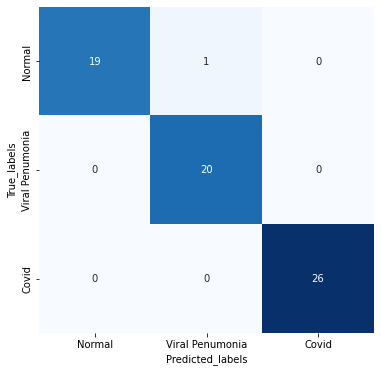

In [19]:
ytest = np.array([])
xtest = []

for i in range(math.ceil(len(test_generator.classes)/batch_size)):
    xtest.append(test_generator[i][0]) 
    ytest= np.concatenate((ytest,test_generator[i][-1])) 
    
xtest = np.concatenate((xtest),axis=0)

ypred_prob =model_vgg16.predict(xtest)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytest,ypred))